# Voting Analysis

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
from datetime import datetime

In [16]:
cwd = os.getcwd()
date_format = "%Y-%m-%d"
TORNADO_PATH = os.path.join(cwd, "..", "data/tornadoes/US_tornadoes_2000_2022.csv")
TORNADO_SHAPEFILE = os.path.join(cwd, "..", "data/geographic/US_tornadoes_1950_2022/US_tornadoes_1950_2022.shp")
COUNTIES_PATH = os.path.join(cwd, "..", "data/counties/2018_counties.csv")
COUNTIES_SHAPEFILE = os.path.join(cwd, "..", "data/geographic/cb_2018_us_county_5m/cb_2018_us_county_5m.shp")
INTERSECTION_PATH = os.path.join(cwd, "..", "data/tornado_county_intersections.csv")
RESULTS_PATH = os.path.join(cwd, "..", "data/results_2000s.csv")

# Naive Comparison

In [103]:
def getCountyVoteSet_FlatCount(data_vote,data_tornado,year):
    output = np.array([[0.0,0]]* len(data_vote))
    
    i = 0
    for row in data_vote.index:
        
        filter1 = data_tornado.loc[data_tornado["GEOID"] == data_vote["fips"][row]]
        filter2 = filter1.loc[filter1["yr"].isin(range(year-4,year+1))]
        output[i,1] = len(filter2)
        output[i,0] = data_vote[str(year)][row]
        # print(i)
        i+=1
    
    return output

def getCountyVoteSet_CostAgg(data_vote,data_tornado,year):
    output = np.array([[0.0,0]]* len(data_vote))
    
    i = 0
    for row in data_vote.index:
        
        filter1 = data_tornado.loc[data_tornado["GEOID"] == data_vote["fips"][row]]
        filter2 = filter1.loc[filter1["yr"].isin(range(year-4,year+1))]
        totalCost = sum(filter2["loss"])
        output[i,1] = totalCost
        output[i,0] = data_vote[str(year)][row]
        # print(i)
        i+=1
    
    return output

def getCountyVoteSet_Casualties(data_vote,data_tornado,year):
    output = np.array([[0.0,0]]* len(data_vote))
    
    i = 0
    for row in data_vote.index:
        
        filter1 = data_tornado.loc[data_tornado["GEOID"] == data_vote["fips"][row]]
        filter2 = filter1.loc[filter1["yr"].isin(range(year-4,year+1))]
        totalCost = sum(filter2["inj"]) + sum(filter2["fat"])
        output[i,1] = totalCost
        output[i,0] = data_vote[str(year)][row]
        # print(i)
        i+=1
    
    return output

    
    


2004


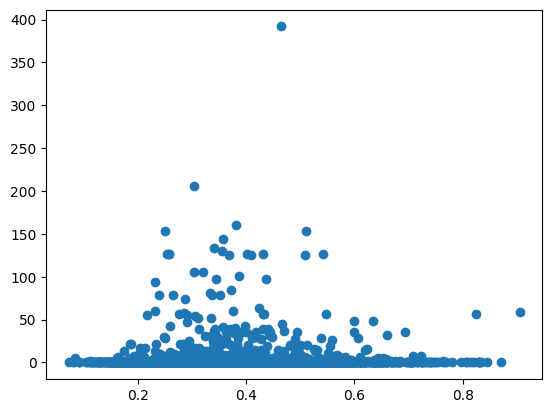

2008


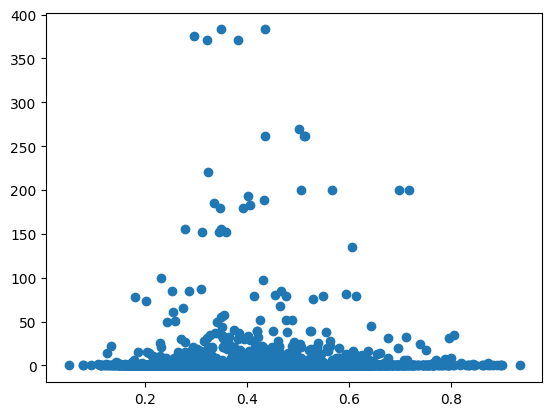

2012


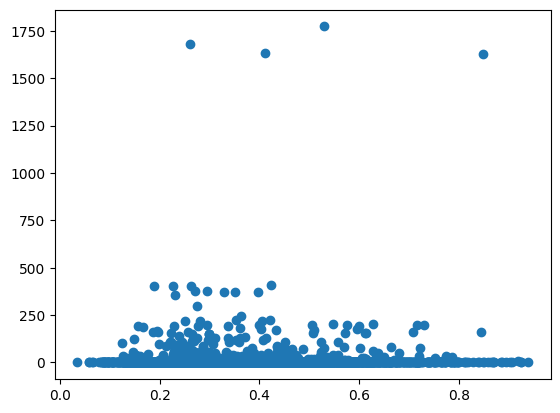

2016


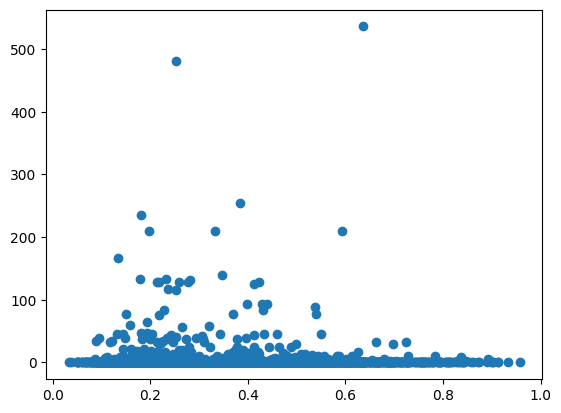

2020


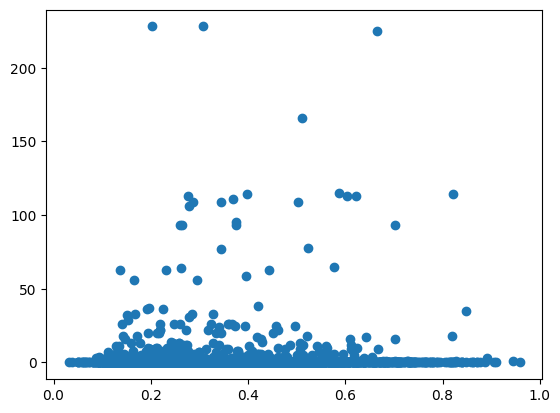

In [104]:
data_tornado = pd.read_csv(INTERSECTION_PATH)
data_voting = pd.read_csv(RESULTS_PATH)
# print(data_voting["fips"])

tornadoes_Dem = []
for year in range(2004, 2021, 4):
    dist_Dem = data_voting.loc[data_voting[str(year)].notnull()]
    
    # tornado_set_Dem = getTornadoSetByCounty(data_tornado, set(dist_Dem), year)
    # tornado_set_Rep = getTornadoSetByCounty(data_tornado, set(dist_Rep), year)
    scatters = getCountyVoteSet_Casualties(dist_Dem,data_tornado,year)
    print(year)
    plt.scatter(scatters[:,0],scatters[:,1])
    plt.show()
    
    

